In [134]:
import ipywidgets as widgets
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

# Modeling Incidence

In this notebook we present modeling of  two metrics of cancer incidence number of tumors located **insitu** per 1000 of totally diagnozed tumors (insitu means that abnormal cells have been found in their place of origin but have not spread to nearby tissues). And number of diagnozed **multiple tumors** per 1000 cases

The following model must reflect ongoing reforms in Ukrainian medical system as well as COVID19 outbreak and full-scale invasion in 2022

In [135]:
st_df = pd.read_csv('./final_dataset/stage_incidence_features.csv')

In [136]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      336 non-null    int64  
 1   region                    336 non-null    object 
 2   mtumors                   336 non-null    float64
 3   syncmtumors               336 non-null    float64
 4   insitu                    336 non-null    float64
 5   ncervix                   336 non-null    float64
 6   nhospotal_pht             336 non-null    float64
 7   nbeds_pht                 336 non-null    float64
 8   ybeds_pht                 336 non-null    float64
 9   nill_pht                  336 non-null    float64
 10  nvillage_ill_pht          336 non-null    float64
 11  bed_days_pht              336 non-null    float64
 12  dvisits_pht               336 non-null    float64
 13  hvisits_pht               336 non-null    float64
 14  ndoctors_p

In [137]:
st_df = st_df.drop(columns=['tincidence_pht', 'mtumors', 'syncmtumors', 'insitu', 'ncervix', 'nvillage_ill_pht',
                            'hvisits_pht', 'ndialysis_pht', 'ndialysis_pht', 'nbacter_pht', 
                            'dumps_not_cleaned_enough', 'nphysic_pht'])

In [138]:
st_df.columns

Index(['year', 'region', 'nhospotal_pht', 'nbeds_pht', 'ybeds_pht', 'nill_pht',
       'bed_days_pht', 'dvisits_pht', 'ndoctors_pht', 'nnursing_pht',
       'nx_ray_pht', 'nflurography_pht', 'nradiology_pht', 'nradlab_pht',
       'nсt_pht', 'ncardiogram_pht', 'ndiaglab_pht', 'nbiochem_pht',
       'ncyto_pht', 'nimun_pht', 'nendoscop_pht', 'nultrasound_pht',
       'air_pollution', 'polluted_dumps', 'not_cleaned_dumps',
       'num_clearing_plants', 'cpi', 'population', 'mtumors_pht',
       'syncmtumors_pht', 'insitu_pht', 'insitu_pti', 'mtumors_pti', 'gdp',
       'aging_level', 'mean_age'],
      dtype='object')

## EDA

### Feature Selection

Let first sort all variables into several groups

1. **Equipment**
2. **Medical Personnel**
3. **Illness**
4. **Environmental**
5. **Socioeconomic**

In [139]:

equipment_variables = [
    'nx_ray_pht', 'nflurography_pht', 'nradiology_pht',
    'nсt_pht', 'ndiaglab_pht', 'nendoscop_pht', 'nultrasound_pht',
]

personnel_variables = ['ndoctors_pht', 'nnursing_pht']

illness_variables = ['nill_pht', 'dvisits_pht']

environmental_variables = ['air_pollution']

socioeconomic_variables = ["gdp", "mean_age"]

all_explanatory_variables = equipment_variables + personnel_variables + illness_variables + environmental_variables + socioeconomic_variables

all_dependent_variables = ['mtumors_pti']

Then, let check correlation table among explanatory variables

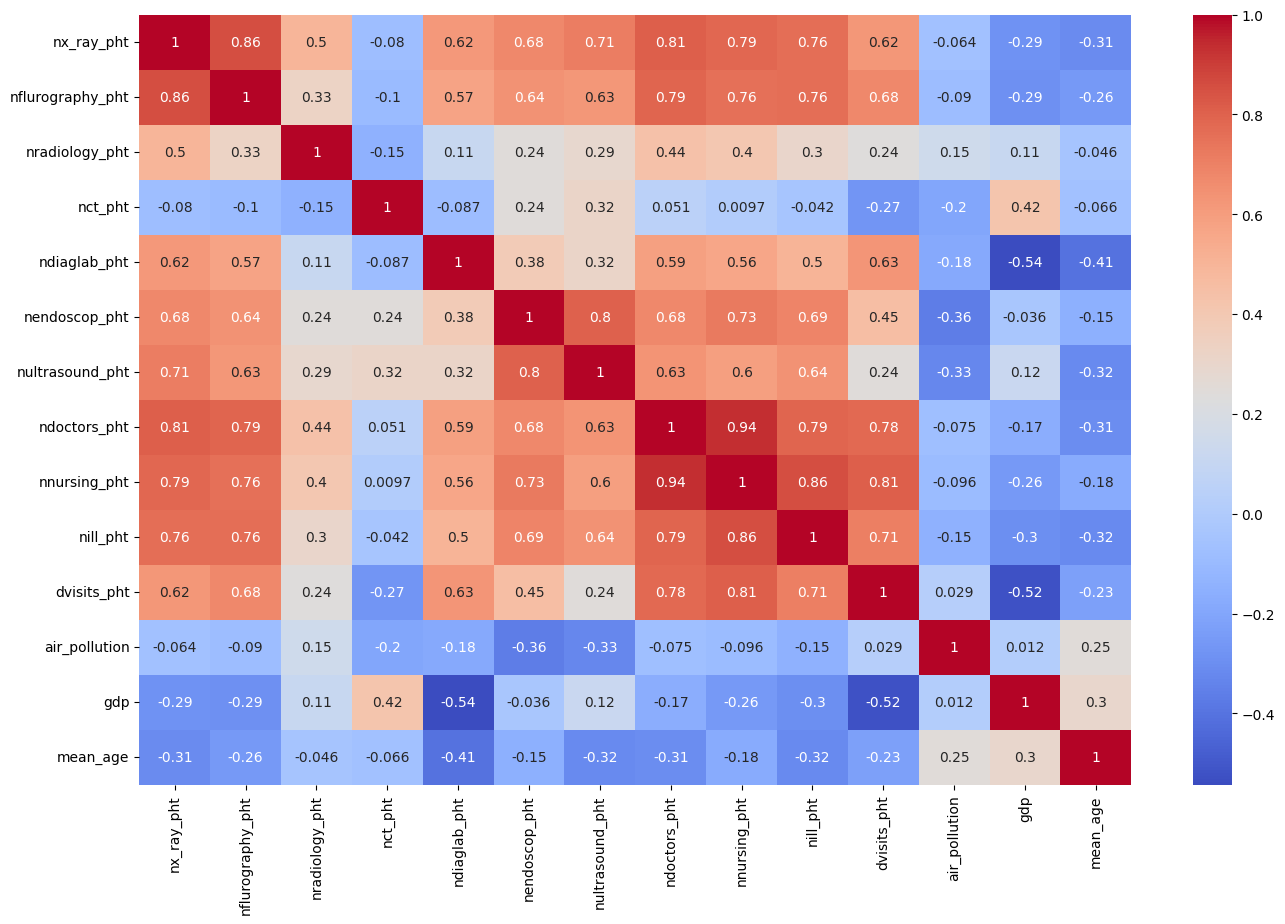

In [140]:
plt.figure(figsize=(16, 10))
correlation_matrix = st_df[all_explanatory_variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

As visible Equipment, personnel and illness variables posesses multicollinearity among themselves. This may be resolved in the following way. First, we create index for availability of equipment - **mdevindex**, which is equal to the average of ndiaglab_pht, nx_ray_pht, nultrasound_pht, nendoscop_pht, nultrasound_pht. nct_pht is left asside, first, because it is barely correlated with other columns, second, because we are particularlry interested in affect of effect of number of CT scans on mtumors_pti

In [141]:
st_df['mdevindex'] = (st_df['ndiaglab_pht'] + \
                     st_df['nx_ray_pht'] + \
                     st_df['nflurography_pht'] + \
                     st_df['nultrasound_pht'] + \
                     st_df['nendoscop_pht']) / 5

Then, we can get rid of **nnursing_pht**, because it is highly correlated with **ndoctors_pht**. And the effect of number of doctors is more interesting for analysis.

In [142]:
st_df = st_df.drop(columns=['nnursing_pht'])

Also, it is visible that nill_pht and dvisits_pht are pretty correlated with ndoctors_pht, then those columns can be divided by ndoctors_pht, to reduce it

In [143]:
st_df['dvisits_pht'] /= st_df['ndoctors_pht']
st_df['nill_pht'] /= st_df['ndoctors_pht']
st_df['mdevindex'] /= st_df['ndoctors_pht']

As result, we get new set of variables

In [144]:
equipment_variables = [
    'nсt_pht', 'mdevindex'
]

personnel_variables = ['ndoctors_pht']

illness_variables = ['dvisits_pht']

environmental_variables = ['air_pollution']

socioeconomic_variables = ["gdp", "mean_age"]

all_explanatory_variables = equipment_variables + personnel_variables + illness_variables + environmental_variables + socioeconomic_variables

all_dependent_variables = ['mtumors_pti']

And uncorrelated set of expanatory variables:

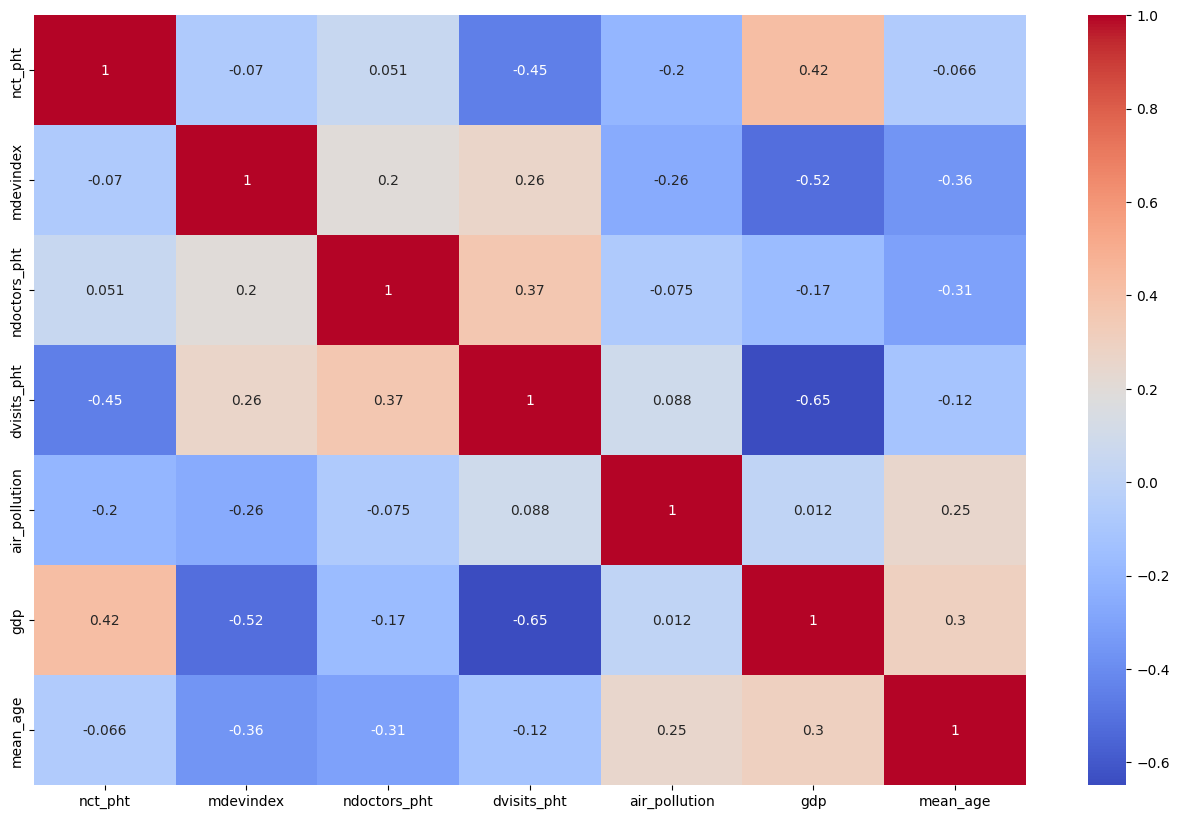

In [145]:
plt.figure(figsize=(16, 10))
correlation_matrix = st_df[all_explanatory_variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [146]:
st_df = st_df[all_dependent_variables + all_explanatory_variables + ['region', 'year']]

### Trend account

In [147]:
st_df = st_df[st_df.year < 2020]
st_df = st_df[~st_df.region.isin(['Донецька', 'Луганська'])]

Firstly, we can add number of years from start of observation as explanatory variable

In [148]:
st_df['t'] = st_df['year'] - 2008

Also in the years of observations medical system had undergone lots of reforms, which are really hard to model. To get rid of these effects, we focus analysis only on the differences between regions. 
Then for each year we can subtract the mean of each variable across all regions. This procedure is only done for equipment, medical personnel and illness variables 

In [149]:

def coupled_detrend(df: pd.DataFrame, x_names: list[str]):
    df = df.copy()
    years = sorted(df.year.unique())
    for x_name in x_names:
        for year in years:
            x_at_year = df[df.year == year][x_name]
            df.loc[df.year == year, x_name] = x_at_year - x_at_year.mean()
    
    return df


In [150]:
st_df = coupled_detrend(st_df, all_explanatory_variables)

In [151]:
st_df = st_df[st_df.air_pollution < st_df.air_pollution.quantile(0.95)]
print(st_df.air_pollution.quantile(0.95))

107.56409090909082


### Scatter plots analysis

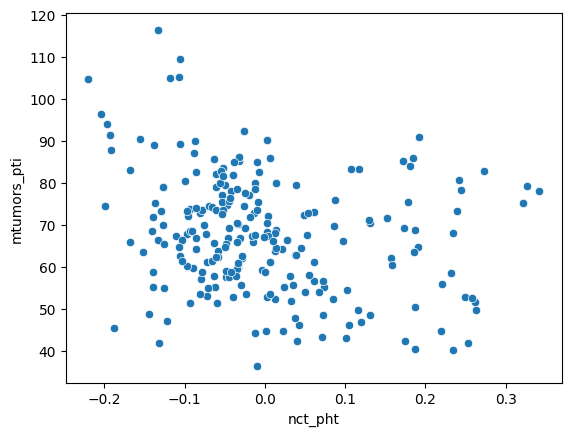

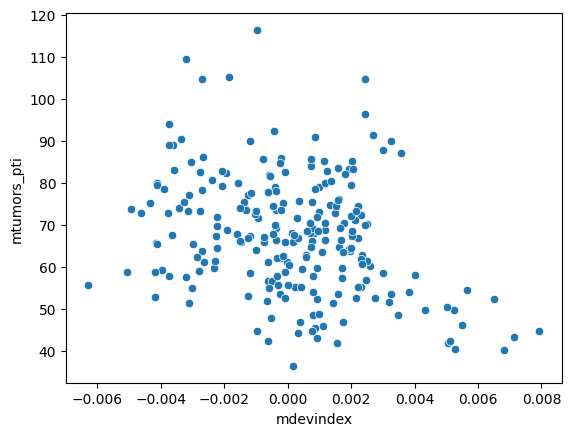

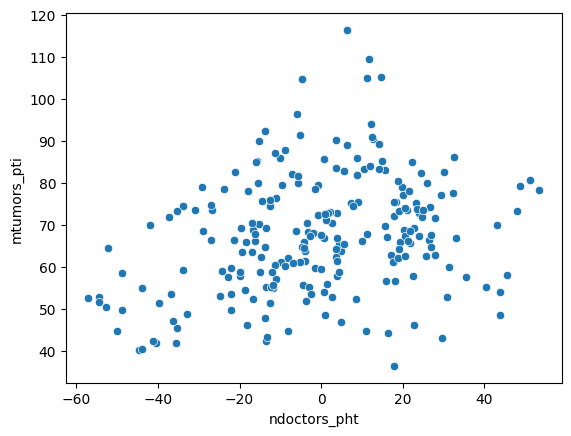

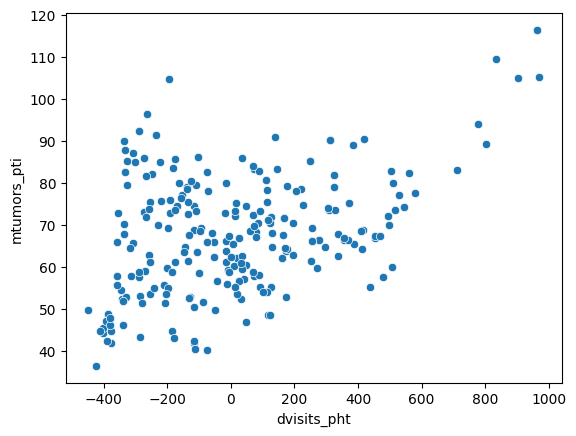

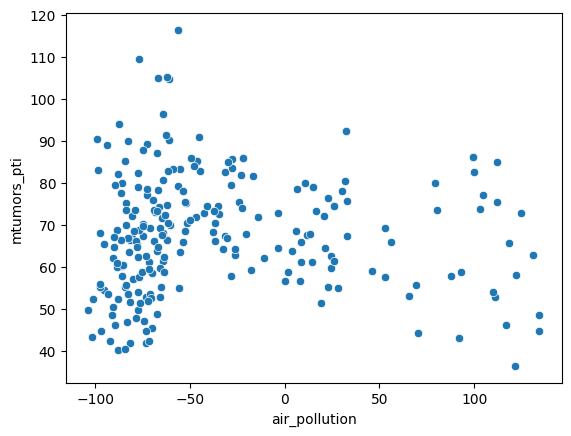

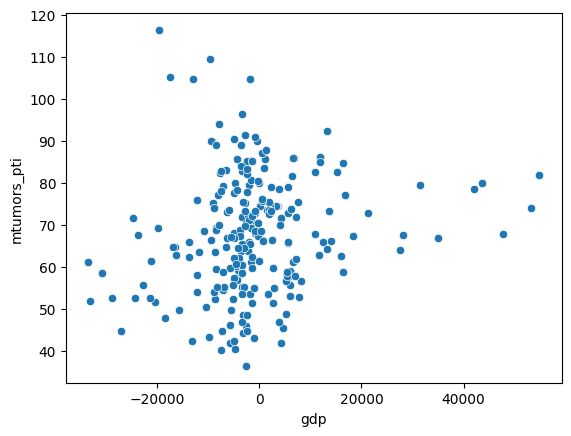

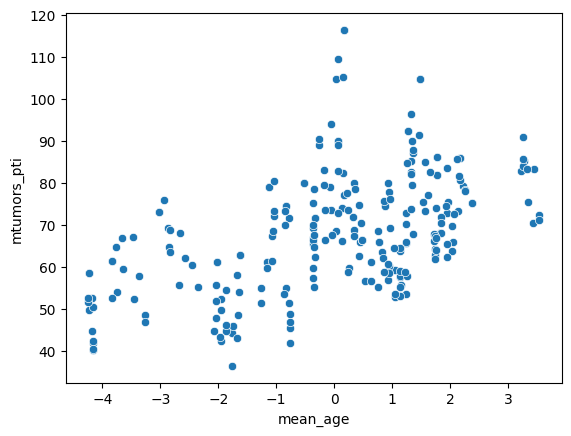

In [152]:
for x_name in all_explanatory_variables:
    sns.scatterplot(st_df, y='mtumors_pti', x=x_name)
    plt.show()

<Axes: xlabel='air_pollution', ylabel='mtumors_pti'>

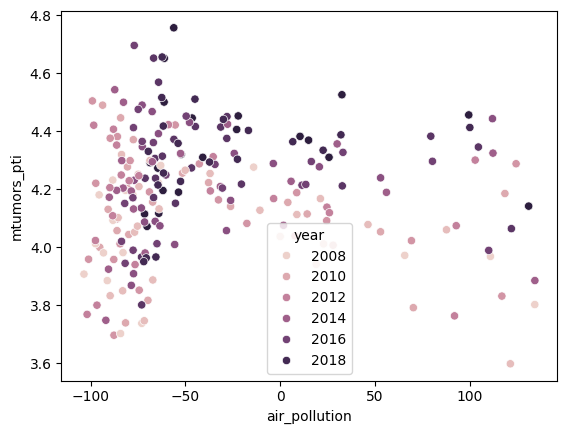

In [160]:
sns.scatterplot(st_df, x='air_pollution', y='mtumors_pti', hue='year')

## Model selection

In [153]:
def select_best_model_for(df: pd.DataFrame, target: str, ommit: list[str]) -> tuple[sm.OLS, list[str]]:
    predictors = df.drop(columns=ommit + [target], errors="ignore")

    predictors = predictors.select_dtypes(include=["number"])
    
    X = predictors.copy()
    y = df[target]
    
    X = sm.add_constant(X)
    
    best_model = sm.OLS(y, X).fit()

    best_aic = np.inf

    to_drop = None

    while len(X.columns) > 0:
        aic_not_changed = True
            
        for col in X.columns:
            temp_X = X.drop(col, axis = 1)
            temp_model = sm.OLS(y, temp_X).fit()
            if temp_model.aic < best_aic:
                best_aic = temp_model.aic
                best_model = temp_model
                to_drop = col
                aic_not_changed = False

        if aic_not_changed:
            break

        X = X.drop(to_drop, axis = 1)
    
    selected_params = list(best_model.params.keys())
    if 'const' in selected_params:
        selected_params.remove('const')

    return best_model, selected_params



In [154]:
ommit = ["age_group", "year", "region", "category",  'mtumors_pht', 'syncmtumors_pht',
         'insitu_pht', 'insitu_pti', 'mtumors_pti', 'ncervix', 'mtumors', 'syncmtumors', 'insitu', 
         'gdp', 'mtumors_pti', 'tincidence', 'cpi', 'ybeds_pht', 'population']

In [155]:
st_df['mtumors_pti'] = np.log(st_df['mtumors_pti'])

In [156]:
mtumors_model, mtumors_selected_params = select_best_model_for(st_df, 'mtumors_pti', ommit)
print(mtumors_model.summary())

                            OLS Regression Results                            
Dep. Variable:            mtumors_pti   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     75.93
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           6.19e-53
Time:                        14:09:32   Log-Likelihood:                 165.93
No. Observations:                 250   AIC:                            -317.9
Df Residuals:                     243   BIC:                            -293.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.0346      0.016    248.917

## Tests

In [157]:
import pandas as pd
import statsmodels.api as sm

X = st_df[all_explanatory_variables]  
X = sm.add_constant(X) 

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

        Variable       VIF
0          const  1.484038
1        nсt_pht  1.123728
2      mdevindex  1.305128
3   ndoctors_pht  1.698205
4    dvisits_pht  1.672881
5  air_pollution  1.765362
6            gdp  1.394559
7       mean_age  1.402566


## Heteroskedastisity

In [158]:
from statsmodels.stats.diagnostic import het_breuschpagan

X = sm.add_constant(st_df[mtumors_selected_params])
y = st_df['mtumors_pti']

model = sm.OLS(y, X).fit(cov_type='HC1')


# bp_test = het_breuschpagan(model.resid, model.model.exog)
# labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
# print(dict(zip(labels, bp_test)))
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            mtumors_pti   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     94.76
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           8.77e-61
Time:                        14:09:32   Log-Likelihood:                 165.93
No. Observations:                 250   AIC:                            -317.9
Df Residuals:                     243   BIC:                            -293.2
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.0346      0.014    297.129